## Initial Data Observation

- read the raw dataset and discover its shape
- plot some characteristics such as the long tail and metrics

## 0. Import Modules

In [1]:
import os
import sys
from pathlib import Path

# setting proper working directory
PROJECT_DIRECTORY = Path(os.path.abspath('')).resolve().parents[0]
sys.path.extend([str(PROJECT_DIRECTORY)])

print(f'Python {sys.version} on {sys.platform}')
print('Project directory: ', PROJECT_DIRECTORY)

Python 3.9.19 (main, Jul  7 2024, 08:52:44) 
[Clang 15.0.0 (clang-1500.3.9.4)] on darwin
Project directory:  /Users/markus/Documents/privat/Studium/Diplomarbeit/ResearchSeminarMusicRecommender2024


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
import seaborn as sns
from src.utilities.Helper import load_data, create_sparse_matrix

## 1. Read the raw Dataset

- `ROWS = None` refers to read the entire dataset

In [3]:
FILENAME = PROJECT_DIRECTORY / "data/raw/user_item_interaction_RAW_ANONYMIZED.txt"
DATASET = "real"
ROWS = None

In [4]:
db_interaction = load_data(FILENAME, rows = ROWS, dataset=DATASET)
print(db_interaction.shape)
print(db_interaction.keys())

(23545542, 2)
Index(['userID', 'itemID'], dtype='object')


In [5]:
print(db_interaction.nunique())

userID    70309
itemID    37408
dtype: int64


### 1.1 Drop Duplicates

Ignore the downloads of different recordtypes. Drop duplicateted subsets of {`userID`,`itemID`}.

In [7]:
db_interaction_without_duplicates = db_interaction.drop_duplicates(subset=["userID", "itemID"], ignore_index=True)
print(db_interaction_without_duplicates.nunique())


userID    70309
itemID    37408
dtype: int64


In [ ]:
# db_interaction_without_duplicates.to_csv("../data/processed/user_item_interaction.txt", sep="\t", encoding='utf-16', index=False)

### 1.2 Build utility matrix

### 1.3 Build Sparse CSR matrix via Scipy

In [14]:
sparse_user_item_interaction, user_index, item_index = create_sparse_matrix(db_interaction_without_duplicates)

print("Number of (users, items): ", sparse_user_item_interaction.shape)

print(sparse_user_item_interaction.getnnz())

Number of (users, items):  (70309, 37408)
17762393


In [15]:
print(sparse_user_item_interaction.todense().shape)
print(f"The memory usage is {round((sparse_user_item_interaction.data.nbytes +  sparse_user_item_interaction.indptr.nbytes + sparse_user_item_interaction.indices.nbytes) / 1024 / 1024,3)} MB")

(70309, 37408)
The memory usage is 203.543 MB


## 2. Discovering Metrics

Evaluating Sparsity

In [16]:
n_total = sparse_user_item_interaction.shape[0]*sparse_user_item_interaction.shape[1]
n_ratings = sparse_user_item_interaction.nnz
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 0.68%


Evaluating the Users Mean / Median

In [17]:
n_downloads_per_user = sparse_user_item_interaction.getnnz(axis=1)
mean_downloads_per_user = n_downloads_per_user.mean()
median_downloads_per_user = np.median(n_downloads_per_user)

print(f"Most user interactions: {n_downloads_per_user.max()}")
print(f"Least user interactions: {n_downloads_per_user.min()}")
print(f"The median / mean is {median_downloads_per_user} / {mean_downloads_per_user} interactions per user.")

Most user interactions: 32850
Least user interactions: 1
The median / mean is 99.0 / 252.63327596751483 interactions per user.


Evaluating the Tracks Mean / Median

In [18]:
n_downloads_per_track = sparse_user_item_interaction.getnnz(axis=0)
mean_downloads_per_track = n_downloads_per_track.mean()
median_downloads_per_track = np.median(n_downloads_per_track)

print(f"Most track interactions: {n_downloads_per_track.max()}")
print(f"Least track interactions: {n_downloads_per_track.min()}")
print(f"The median / mean is {median_downloads_per_track} / {mean_downloads_per_track} interactions per track.")

Most track interactions: 14392
Least track interactions: 1
The median / mean is 206.0 / 474.8287264756202 interactions per track.


In [19]:
x = n_downloads_per_track
y = n_downloads_per_track / n_downloads_per_track.sum()

## 3. Filter Users by Threshold

Only take users and items into account which have at least $20$ downloads. 

In [20]:
print(sparse_user_item_interaction.shape)

(70309, 37408)


In [8]:
THRESHOLD = 20

filter_tracks = db_interaction_without_duplicates['itemID'].value_counts() > THRESHOLD
filter_tracks = filter_tracks[filter_tracks].index.tolist()

filter_users = db_interaction_without_duplicates['userID'].value_counts() >= THRESHOLD
filter_users = filter_users[filter_users].index.tolist()

db_interaction_without_duplicates_and_below_median = db_interaction_without_duplicates[db_interaction_without_duplicates['userID'].isin(filter_users)]
db_interaction_without_duplicates_and_below_median = db_interaction_without_duplicates_and_below_median[db_interaction_without_duplicates_and_below_median['itemID'].isin(filter_tracks)]

#  db_interaction_without_duplicates_and_below_median.to_csv("../data/processed/user_item_interaction_FILTERED_ANONYMIZED.txt", sep="\t", encoding='utf-16', index=False)

In [9]:
print(db_interaction_without_duplicates_and_below_median.shape)

(17665904, 2)


In [24]:
sparse_user_item_interaction, user_index, item_index = create_sparse_matrix(db_interaction_without_duplicates_and_below_median)

print("Number of (users, items): ", sparse_user_item_interaction.shape)

print(sparse_user_item_interaction.getnnz())

Number of (users, items):  (58747, 37370)
17665904


In [25]:
n_total = sparse_user_item_interaction.shape[0]*sparse_user_item_interaction.shape[1]
n_ratings = sparse_user_item_interaction.nnz
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 0.8%


In [26]:
n_downloads_per_user = sparse_user_item_interaction.getnnz(axis=1)
mean_downloads_per_user = n_downloads_per_user.mean()
median_downloads_per_user = np.median(n_downloads_per_user)

print(f"Most user interactions: {n_downloads_per_user.max()}")
print(f"Least user interactions: {n_downloads_per_user.min()}")
print(f"The median / mean is {median_downloads_per_user} / {mean_downloads_per_user} interactions per user.")

Most user interactions: 32833
Least user interactions: 20
The median / mean is 133.0 / 300.71159378351234 interactions per user.


In [27]:
n_downloads_per_track = sparse_user_item_interaction.getnnz(axis=0)
mean_downloads_per_track = n_downloads_per_track.mean()
median_downloads_per_track = np.median(n_downloads_per_track)

print(f"Most track interactions: {n_downloads_per_track.max()}")
print(f"Least track interactions: {n_downloads_per_track.min()}")
print(f"The median / mean is {median_downloads_per_track} / {mean_downloads_per_track} interactions per track.")

Most track interactions: 14037
Least track interactions: 21
The median / mean is 205.0 / 472.72956917313354 interactions per track.


## 4. Plot the Long-Tail

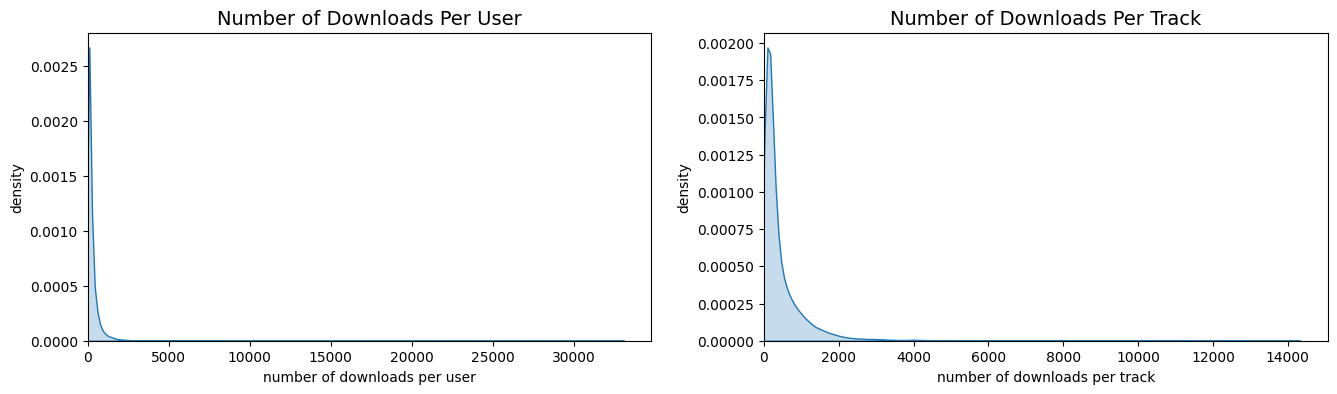

In [28]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_downloads_per_user, fill=True)
plt.xlim(0)
plt.title("Number of Downloads Per User", fontsize=14)
plt.xlabel("number of downloads per user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_downloads_per_track, fill=True)
plt.xlim(0)
plt.title("Number of Downloads Per Track", fontsize=14)
plt.xlabel("number of downloads per track")
plt.ylabel("density")
plt.show()

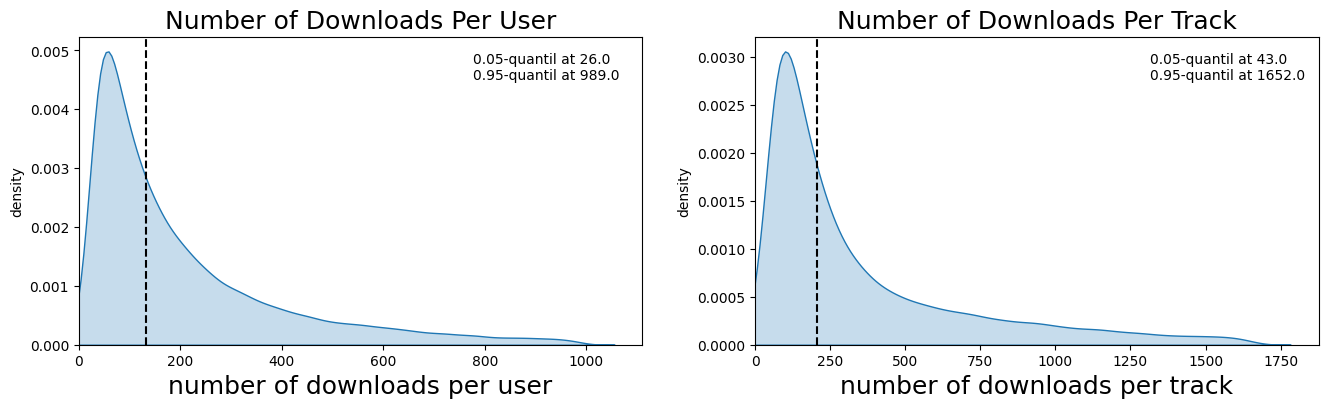

In [29]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
median_user = np.median(n_downloads_per_user)
median_track = np.median(n_downloads_per_track)

ax1 = sns.kdeplot(n_downloads_per_user[(n_downloads_per_user >= np.quantile(n_downloads_per_user, 0.05, method="weibull")) & (n_downloads_per_user <= np.quantile(n_downloads_per_user, 0.95, method="weibull"))], fill=True)
ax1.axvline(median_user, color='k', linestyle='--')
ax1.text(0.7,0.9,f"0.05-quantil at {round(np.quantile(n_downloads_per_user, 0.05, method='weibull'),2)}\n0.95-quantil at {round(np.quantile(n_downloads_per_user, 0.95, method='weibull'),2)}", horizontalalignment='left', verticalalignment='center', transform=ax1.transAxes)
plt.xlim(0)
plt.title("Number of Downloads Per User", fontsize=18)
plt.xlabel("number of downloads per user", fontsize=18)
plt.ylabel("density")
plt.subplot(1,2,2)
ax2 = sns.kdeplot(n_downloads_per_track[(n_downloads_per_track >= np.quantile(n_downloads_per_track, 0.05, method="weibull")) & (n_downloads_per_track <= np.quantile(n_downloads_per_track, 0.95, method="weibull"))], fill=True)
ax2.axvline(median_track, color='k', linestyle='--')
ax2.text(0.7,0.9,f"0.05-quantil at {round(np.quantile(n_downloads_per_track, 0.05, method='weibull'),2)}\n0.95-quantil at {round(np.quantile(n_downloads_per_track, 0.95, method='weibull'),2)}", horizontalalignment='left', verticalalignment='center', transform=ax2.transAxes)
plt.xlim(0)
plt.title("Number of Downloads Per Track", fontsize=18)
plt.xlabel("number of downloads per track", fontsize=18)
plt.ylabel("density")
plt.show()

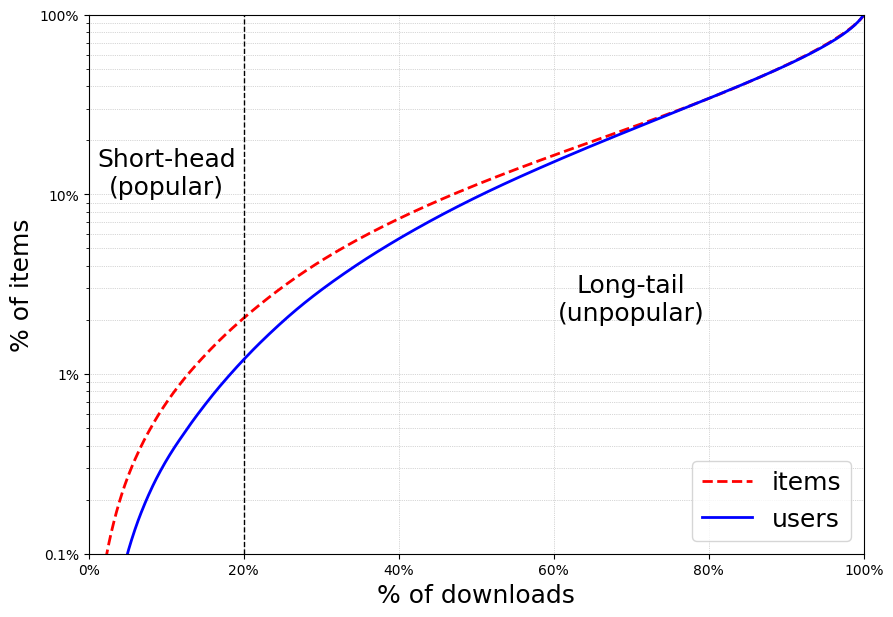

In [30]:
# Function to compute the cumulative distribution
def compute_cumulative_distribution(downloads):
    sorted_downloads = np.sort(downloads)[::-1]
    sorted_downloads = np.cumsum(sorted_downloads)
    cumulative_counts = np.arange(1, len(sorted_downloads) + 1)

    percentage_items = sorted_downloads / sorted_downloads.max() * 100
    cumulative_counts = cumulative_counts / len(cumulative_counts) * 100

    return percentage_items, cumulative_counts

# Compute cumulative distributions
x, y = compute_cumulative_distribution(n_downloads_per_track)

# Plotting
plt.figure(figsize=(10, 7))

# Netflix data
plt.plot(x, y, label='items', color='red', linewidth=2, linestyle="--")

plt.axvline(x=20, color='black', linestyle='--', linewidth=1)

x, y = compute_cumulative_distribution(n_downloads_per_user)
plt.plot(x, y, label='users', color='blue', linewidth=2)

# Add text annotations
plt.text(10, 10, 'Short-head\n(popular)', fontsize=18, ha='center')
plt.text(70, 2, 'Long-tail\n(unpopular)', fontsize=18, ha='center')

# Set logarithmic scale for y-axis
plt.yscale('log')
plt.ylim(0.1, 100)

# Set labels and title
plt.xlabel('% of downloads', fontsize=18)
plt.ylabel('% of items', fontsize=18)
# plt.title('Distribution of Items by Ratings', fontsize=16)
plt.yticks([0.1, 1, 10, 100], ['0.1%', '1%', '10%', '100%'])
plt.xticks([0, 20, 40, 60, 80, 100], ['0%', '20%', '40%', '60%', '80%', '100%'])
plt.xlim(0, 100)

# Add legend
plt.legend(loc='best', fontsize=18)

# Show grid
plt.grid(True, which='both', linestyle=':', linewidth=0.5)

plt.savefig('../data/processed/demo.png', format='png', transparent=True)

# Show plot
plt.show()

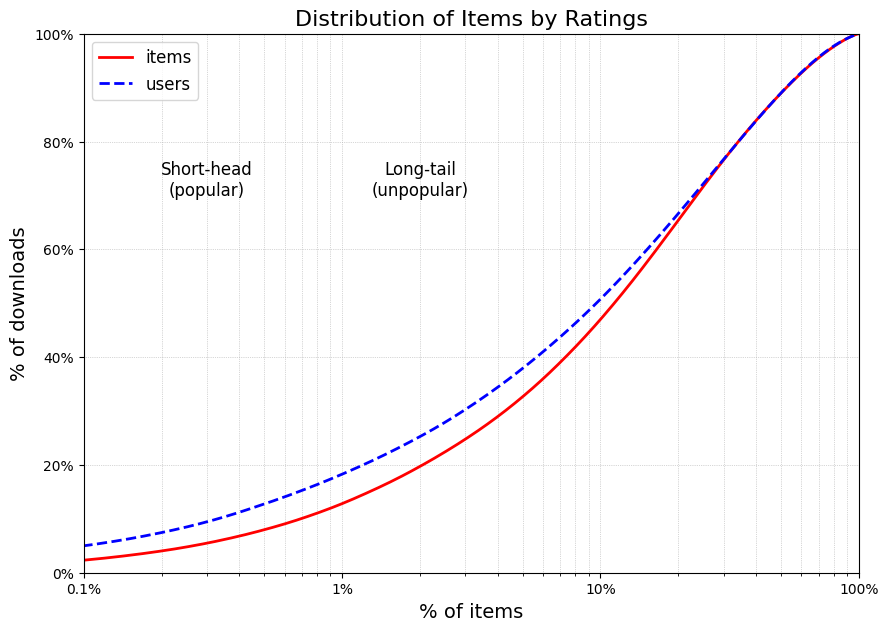

In [31]:
# Function to compute the cumulative distribution
def compute_cumulative_distribution(downloads):
    sorted_downloads = np.sort(downloads)[::-1]
    sorted_downloads = np.cumsum(sorted_downloads)
    cumulative_counts = np.arange(1, len(sorted_downloads) + 1)

    percentage_items = sorted_downloads / sorted_downloads.max() * 100
    cumulative_counts = cumulative_counts / len(cumulative_counts) * 100

    return percentage_items, cumulative_counts

# Compute cumulative distributions
y, x = compute_cumulative_distribution(n_downloads_per_track)

# Plotting
plt.figure(figsize=(10, 7))

# Netflix data
plt.plot(x, y, label='items', color='red', linewidth=2)

y, x = compute_cumulative_distribution(n_downloads_per_user)
plt.plot(x, y, label='users', color='blue', linewidth=2, linestyle="--")

# Add text annotations
plt.text(0.3, 70, 'Short-head\n(popular)', fontsize=12, ha='center')
plt.text(2, 70, 'Long-tail\n(unpopular)', fontsize=12, ha='center')

# Set logarithmic scale for y-axis
plt.xscale('log')
plt.xlim(0.1, 100)
plt.xticks([0.1, 1, 10, 100], ['0.1%', '1%', '10%', '100%'])

# Set labels and title
plt.ylabel('% of downloads', fontsize=14)
plt.xlabel('% of items', fontsize=14)
plt.ylim(0, 100)
plt.yticks([0, 20, 40, 60, 80, 100], ['0%', '20%', '40%', '60%', '80%', '100%'])
plt.title('Distribution of Items by Ratings', fontsize=16)

# Add legend
plt.legend(loc='best', fontsize=12)

# Show grid
plt.grid(True, which='both', linestyle=':', linewidth=0.5)

# Show plot
plt.show()